# Trying to do the inversion problem

Having done this, we can now try to invert the problem. The first strategy is going to be the following. We will use the Gaussian as the initial condition of our problem, and $u(0,t_f)$ as an additional loss to the network. We will force then the solution to fullfill that the center point is $u(0,t_f)$ and leave $\nu$ as a learneable parameter for the NN. Note that since 2D Bundle Solver is not yet implemented in Neurodiffeq, we willt ry to invert the problem for certain values of $\nu$. The next step would be to try to implement 2D Bundle Solver and try to recover the whole boundary curve.

# KPZ equation

We will first try to treat KPZ equation with usual numerical methods. Then, we will try to implement it in the NN and try to get some insights. This equation is given by

$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} \,=\, \nu \frac{\partial ^2 u}{\partial x^2} -\lambda \partial_x \eta(x,t)
$$

In [1]:
import neurodiffeq
from neurodiffeq.conditions import DirichletBVP2D
from neurodiffeq.solvers import Solver2D, BaseSolution
from neurodiffeq.monitors import Monitor2D
from generators import *
from neurodiffeq.conditions import IBVP1D,BaseCondition
from neurodiffeq.networks import FCNN
from neurodiffeq import diff
from neurodiffeq.callbacks import ActionCallback 
import torch
from torch.optim import lr_scheduler
from neurodiffeq.pde import make_animation
from MHBundleSolver2D_BC import *
from torch import nn as nn
import tqdm as tqdm
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pickle

class DoSchedulerStep(ActionCallback):
    def __init__(self, scheduler):
        super().__init__()
        self.scheduler = scheduler

    def __call__(self, solver):
        self.scheduler.step()
        
def _requires_closure(optimizer):
    # starting from torch v1.13, simple optimizers no longer have a `closure` argument
    closure_param = inspect.signature(optimizer.step).parameters.get('closure')
    return closure_param and closure_param.default == inspect._empty


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [2]:
import os
plot_path = 'Plots/KPZ_first_more_neurons/'


# Check if directory exists, and if not, create it
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
    print(f"Directory '{plot_path}' created.")
else:
    print(f"Directory '{plot_path}' already exists.")

Directory 'Plots/KPZ_first_more_neurons/' already exists.


In [3]:
!nvidia-smi

Thu Jun  5 13:52:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H100 PCIe               Off |   00000000:19:00.0 Off |                    0 |
| N/A   60C    P0            250W /  350W |    5164MiB /  81559MiB |     75%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# Define the NN class 

In [4]:
class NET(nn.Module):
    def __init__(self, H_model, head_model):
        super(NET, self).__init__()
        self.H_model = H_model
        self.head_model = head_model

    def forward(self, x):
        x = self.H_model(x)
        x = self.head_model(x)
        #x = gaussian_smooth_2d(x, sigma=20,kernel_size=7)
        return x
    
class NET_Gaussian(nn.Module):
    def __init__(self, H_model, head_model):
        super(NET, self).__init__()
        self.H_model = H_model
        self.head_model = head_model

    def forward(self, x):
        x = self.H_model(x)
        x = self.head_model(x)
        
        return x

# MULTIHEAD NN FREEZE #
class NET_FREEZE(nn.Module):
    def __init__(self, H_model, head_model):
        super(NET_FREEZE, self).__init__()

        for param in H_model.parameters():
            param.requires_grad = False
        self.H_model = H_model
        self.head_model = head_model
        # Freeze the parameters of H_model
        #for param in self.H_model.parameters():
            #param.requires_grad = False

    def forward(self, x):
        x = self.H_model(x)
        x = self.head_model(x)
        return x
    
def save_model(solver,path,nu_list):
    H_state = solver.best_nets_list[0][0].H_model.state_dict()
    head_state = []
    #nu_list = solver.nu_list
    loss = solver.metrics_history['r2_loss']
    global_epoch = len(loss)
    optim_state = solver.optimizer.state_dict()
    for i in range(len(solver.best_nets_list)):
        head_state.append(solver.best_nets_list[i][0].head_model.state_dict())
    mega_data = {
        "H_state": H_state,
        "head_state": head_state,
        "Loss": loss,
        "optim": optim_state,
        "body_units": body_units,
        "basis": basis_length,
        'nu_list': nu_list
                 }
    torch.save(mega_data, path+ 'Burguers_'+ str(global_epoch))

def load_nets(path,nets,optim,solver):
  master_dict = torch.load(path,map_location=torch.device('cpu'))
  H_state = master_dict['H_state']
  head_state = master_dict['head_state']
  optim_state = master_dict['optim']
  loss = master_dict['Loss']
  global_epoch = len(loss)
  #solver.global_epoch = global_epoch
  solver.metrics_history['train_loss'] = loss
  solver.metrics_history['valid_loss'] = loss
  solver.metrics_history['r2_loss'] = loss
  for i in range(len(nets[:,0])):
    nets[i,0].H_model.load_state_dict(H_state)
    for j in range(n_heads):
      print(j)
      nets[i,j].head_model.load_state_dict(head_state[j])
      #solver.best_nets_list[i,j] = nets[i,j]
  #optim.load_state_dict(optim_state)

# For the smoothenin #
def gaussian_2d_kernel(size=5, sigma=1.0, device="cpu", dtype=torch.float32):
    """Creates a 2D Gaussian kernel."""
    x = torch.arange(-size//2 + 1, size//2 + 1, dtype=dtype, device=device)
    y = torch.arange(-size//2 + 1, size//2 + 1, dtype=dtype, device=device)
    xx, yy = torch.meshgrid(x, y, indexing="ij")

    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
    kernel /= kernel.sum()  # Normalize

    return kernel.view(1, 1, size, size)  # Shape: (out_channels, in_channels, H, W) # Normalize


def gaussian_smooth_2d(u, kernel_size=5, sigma=1.0):
    """Smooths a 2D function u(t, x) using a 2D Gaussian filter with reflection padding."""
    device, dtype = u.device, u.dtype
    kernel = gaussian_2d_kernel(kernel_size, sigma, device, dtype)

    # Add batch and channel dimensions
    u = u.unsqueeze(0).unsqueeze(0)  

    # Apply reflection padding before convolution
    pad = kernel_size // 2
    u_padded = F.pad(u, (pad, pad, pad, pad), mode="reflect")  

    smoothed = F.conv2d(u_padded, kernel)
    return smoothed.squeeze()

    

# Generate the equations

In [5]:
# Generate the fixed noise and save it #
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Domain parameters
nx = 100
tmax = 5
xmin = -5
xmax = 5
dx = (xmax - xmin) / (nx - 1)
nu = 0.1
sigma = 1.0
dt = sigma * (tmax)/nx

# Stochastic parameters
lam = 0.1       # lambda in front of noise term
D = 1e-1         # noise amplitude

# Initial condition
x = np.linspace(xmin, xmax, nx)
u = np.exp(-x**2 / 2)
u_initial = u.copy()
t_list = np.arange(0, tmax, dt)

# Derivative operator for noise (central diff)
def grad(f):
    return (np.roll(f, -1) - np.roll(f, 1)) / (2 * dx)

def burgers_step_stochastic(u, dt, dx, nu, lam, D):
    u_new = u.copy()
    
    # White noise η at this time step
    eta = np.random.randn(nx) * np.sqrt(2 * D / dt)  # eta ~ Gaussian
    eta_x = grad(eta)                                # ∂η/∂x
    noise_term = -lam * eta_x
    # Update using finite difference scheme
    for i in range(1, nx - 1):
        convection = -dt / dx * u[i] * (u[i] - u[i - 1])
        diffusion = nu * dt / dx**2 * (u[i + 1] - 2 * u[i] + u[i - 1])
        u_new[i] = u[i] + convection + diffusion + dt * noise_term[i]

    return u_new,noise_term

# Time loop
n = 0
Ugrid = []
Noise_grid = []
total_steps = int(tmax / dt)
pbar = tqdm(total=total_steps, desc="Solving Stochastic Burgers", ncols=100)
while n * dt < tmax:
    Ugrid.append(u.copy())
    u,noise = burgers_step_stochastic(u, dt, dx, nu, lam, D)
    Noise_grid.append(noise.copy())
    pbar.update(1)
    n += 1
    
    # Plot every 10%
    if (n / (total_steps + 1) * 100) % 10 == 0:
        plt.plot(x, u, label=f"t={n * dt:.2f}")
        plt.title(f"Stochastic Burgers | ν={nu}, λ={lam}")
        plt.xlabel("x")
        plt.ylabel("u(x,t)")
        plt.legend()
        plt.show()

data = {
    "Ugrid": Ugrid,
    "Noise_grid": Noise_grid,
    "x": x,
    "t": np.arange(0, tmax, dt),
    "nu": nu,
}

np.savetxt(plot_path + 'noise.txt',data['Noise_grid'])

Solving Stochastic Burgers:   0%|                                           | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_1074035/1787492079.py:39: RuntimeWarning: overflow encountered in scalar multiply
  convection = -dt / dx * u[i] * (u[i] - u[i - 1])
/tmp/ipykernel_1074035/1787492079.py:41: RuntimeWarning: invalid value encountered in scalar add
  u_new[i] = u[i] + convection + diffusion + dt * noise_term[i]
/tmp/ipykernel_1074035/1787492079.py:40: RuntimeWarning: invalid value encountered in scalar subtract
  diffusion = nu * dt / dx**2 * (u[i + 1] - 2 * u[i] + u[i - 1])
/tmp/ipykernel_1074035/1787492079.py:39: RuntimeWarning: invalid value encountered in scalar subtract
  convection = -dt / dx * u[i] * (u[i] - u[i - 1])
/tmp/ipykernel_1074035/1787492079.py:40: RuntimeWarning: invalid value encountered in scalar add
  diffusion = nu * dt / dx**2 * (u[i + 1] - 2 * u[i] + u[i - 1])


In [6]:
def generate_equations(n_heads):
  eq_dict = {} # Initialize the dictionary
  # Loop to create functions
  for head in range(n_heads):
      # Define a new function using a lambda or nested function
      def make_equations(head):
        def burguers(u,x,t,nu):
            term1 = diff(u,t)
            term2 = u* diff(u,x)
            term3 = -nu* diff(u,x,order = 2)
            term4 = -torch.tensor([data['Noise_grid']]).reshape_as(term1)
            return [term1 +term2 + term3 + term4]
        return burguers
      # Store the function in the dictionary
      eq_dict.update({f'equations_{head}':make_equations(head)})  # Now at the correct indentation level
  print('Equations dictionary generated')
  print(eq_dict)
  return eq_dict


# Define initial condition 

In [7]:
# Define the boundary condition #
def init_gauss(x,a,sigma):
    return a/(np.sqrt(2*np.pi)*sigma)*torch.exp(-x**2 /(2*sigma**2))

def init_sine(x,a,n):
    return a*(torch.sin(x * n * np.pi / 5))**2

def init_N_wave(x,a,b):
    return a*torch.exp(-(x-1)**2 / 2) -b*torch.exp(-(x+1)**2 / 2)

def init_cos(x,a,n):
    return a*(torch.cos(x * n * np.pi /10))**2

# Define the input for the solver

In [8]:
# Initialize t_min, t_max, a_min and a_max
use_Latex = True
# Parameters of the model#

t_min = 0.0
t_max = 5.0

x_min = -5
x_max = +5


#nu_min = -3
#nu_max = 0
# Create the generators #
nu_list = torch.logspace(-2, 0, 1)  # List of nu values for the PDEs
print(nu_list)
data['Noise_grid'],__ = np.meshgrid(data['Noise_grid'],nu_list.cpu().detach().numpy()
,indexing = 'ij')

t_list = torch.linspace(t_min, t_max,100)  # Time values
x_list = torch.linspace(x_min, x_max, 100)  # Spatial values
T,X,N = torch.meshgrid(t_list, x_list, nu_list, indexing='ij')  # Create a meshgrid for t, x, and nu

train_generator = PredefinedGenerator(X,T,N)

init_cond = []
for i in range(1):
    init_cond.append([BundleIBVP1D(t_min=t_min, t_min_val=lambda x: init_gauss(x,0.5,1.0),
            x_min = x_min ,x_min_val= lambda t: 0,
            x_max = x_max ,x_max_val= lambda t: 0),
        BundleIBVP1D(t_min=t_min, t_min_val=lambda x: init_gauss(x,0.5,0.5)+0.2,
            x_min = x_min ,x_min_val= lambda t: 0,
            x_max = x_max ,x_max_val= lambda t: 0),
        BundleIBVP1D(t_min=t_min, t_min_val=lambda x: init_sine(x,1.0,1),
            x_min = x_min ,x_min_val= lambda t: 0,
            x_max = x_max ,x_max_val= lambda t: 10),
        BundleIBVP1D(t_min=t_min, t_min_val=lambda x: init_N_wave(x,1.0,1.0),
            x_min = x_min ,x_min_val= lambda t: 0,
            x_max = x_max ,x_max_val= lambda t: 0),
        #BundleIBVP1D(t_min=t_min, t_min_val=lambda x: 0,
        #    x_min = x_min ,x_min_val= lambda t: init_sine(t,1.0,1.0),
        #    x_max = x_max ,x_max_val= lambda t: init_sine(t,1.0,1.0)),
        #BundleIBVP1D(t_min=t_min, t_min_val=lambda x: 0,
        #    x_min = x_min ,x_min_val= lambda t: init_sine(t,1.0,2.0),
        #    x_max = x_max ,x_max_val= lambda t: init_sine(t,1.0,2.0))
       # BundleIBVP1D(t_min=t_min, t_min_val=lambda x: init_cos(x,1.0,1.0),
       #     x_min = x_min ,x_min_val= lambda t: 0,
       #     x_max = x_max ,x_max_val= lambda t: 0)
    ])

init_cond = np.array(init_cond)
print(init_cond.shape)

n_heads = int(len(init_cond[0,:]))

body_units = [256,256,256,256]
basis_length = 6

# Create the body and the nets #
H = [FCNN(n_input_units=3, hidden_units= body_units, n_output_units = basis_length) for _ in range(1)]

heads = [[nn.Linear(in_features=basis_length,out_features=1,bias=False) for _ in range(n_heads)]for _ in 
         range(len(H))]

nets = np.ones([len(H),n_heads],dtype=nn.Module) # i -> equation, j -> head #
for i in range(len(H)):
    #print(i)
    for j in range(n_heads):
        nets[i,j] = NET(H[i],heads[i][j])

# Create the equations #
eq_dict = {}
eq_dict = generate_equations(n_heads = n_heads)
#print(self.eq_dict)
equation_list = []
for head in range(n_heads):
    equations = eq_dict[f'equations_{head}']
    #print(equations)
    equation_list.append(equations)

print('Equation list ready')

print(nets.shape)

#gen = Generator1D(48,t_min,t_max,'equally-spaced-noisy')

adam = torch.optim.Adam([ p for q in range(n_heads) for net in list(nets[:,q]) for p in net.parameters()],
                        lr=5e-3)

# Warm-up for 5 epochs (linear increase from 0 to 0.001)
warmup_scheduler = torch.optim.lr_scheduler.LinearLR(adam, start_factor=1e-3, total_iters=1000)
main_scheduler = torch.optim.lr_scheduler.StepLR(adam, step_size=1000, gamma=0.975)
scheduler = torch.optim.lr_scheduler.SequentialLR(adam, schedulers=[warmup_scheduler, main_scheduler], milestones=[1100])
scheduler_cb = DoSchedulerStep(scheduler=scheduler)



tensor([0.0100], device='cuda:0')
(1, 4)
Equations dictionary generated
{'equations_0': <function generate_equations.<locals>.make_equations.<locals>.burguers at 0x155472e42680>, 'equations_1': <function generate_equations.<locals>.make_equations.<locals>.burguers at 0x155472e425f0>, 'equations_2': <function generate_equations.<locals>.make_equations.<locals>.burguers at 0x155472e42710>, 'equations_3': <function generate_equations.<locals>.make_equations.<locals>.burguers at 0x155472e427a0>}
Equation list ready
(1, 4)


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/torch/_compile.py:24: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return torch._dynamo.disable(fn, recursive)(*args, **kwargs)


# Define the solver

In [9]:
# Initialize the solver
solver = MHSolver2D(pde_system=equation_list,
                   conditions= init_cond,
                    all_nets= nets,
                    conditions_list = init_cond,
                    train_generator = train_generator,
                    valid_generator = None,
                    xy_min= (x_min,t_min), xy_max=(x_max,t_max),
                    eq_param_index = (0,),
                    n_batches_valid = 0,
                    n_batches_train = 1,
                    n_samplings =100,
                    optimizer = adam
                   )


head 0
Inside solver __init()__: <function generate_equations.<locals>.make_equations.<locals>.burguers at 0x155472e42680>
head 1
Inside solver __init()__: <function generate_equations.<locals>.make_equations.<locals>.burguers at 0x155472e425f0>
head 2
Inside solver __init()__: <function generate_equations.<locals>.make_equations.<locals>.burguers at 0x155472e42710>
head 3
Inside solver __init()__: <function generate_equations.<locals>.make_equations.<locals>.burguers at 0x155472e427a0>


In [10]:
solver.generator['train']

SamplerGenerator(size=100, generator=PredefinedGenerator(size=100, xs=[tensor(shape=(10000,)), tensor(shape=(10000,)), tensor(shape=(10000,))]))

In [11]:
nets[0,0].head_model

Linear(in_features=6, out_features=1, bias=False)

In [ ]:
solver.fit(max_epochs=100000-solver.global_epoch,callbacks=[scheduler_cb])
save_model(solver, plot_path,nu_list)

Training Progress:   0%|          | 0/93896 [00:00<?, ?it/s]

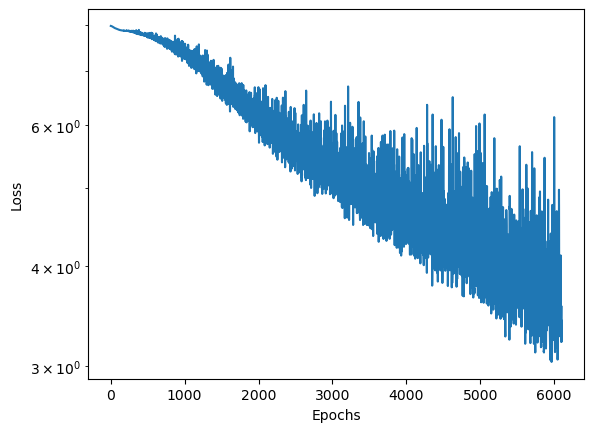

Learning rate  0.004405478466796875


<Figure size 640x480 with 0 Axes>

In [19]:
plt.figure()
plt.plot(solver.metrics_history['r2_loss'])
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()
plt.savefig(plot_path + 'loss.pdf')
#adam.param_groups[0]['lr'] = 2.5e-6
print('Learning rate ',adam.param_groups[0]['lr'])

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /dev/shm/nix-build-py-torch-2.2.2.drv-0/nixbld1/spack-stage-py-torch-2.2.2-mrga1lajkybghn1l6sc83lyspvbakfzk/spack-src/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


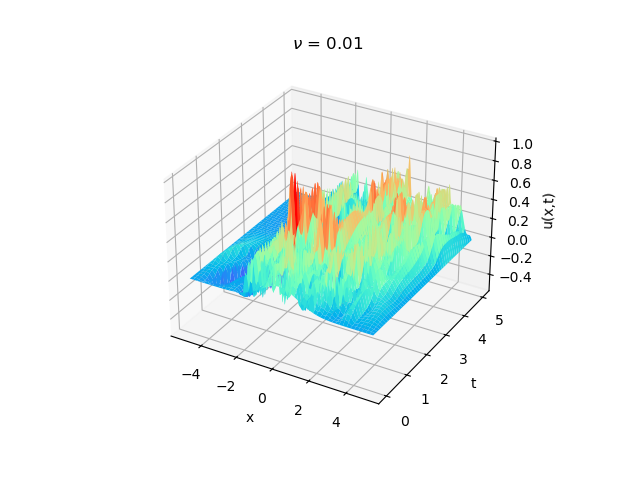

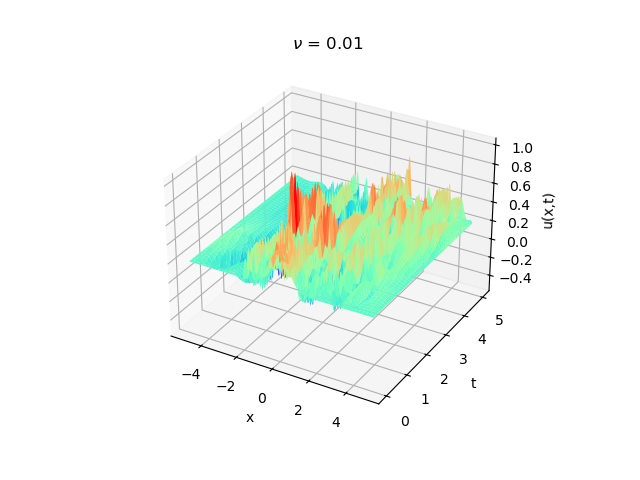

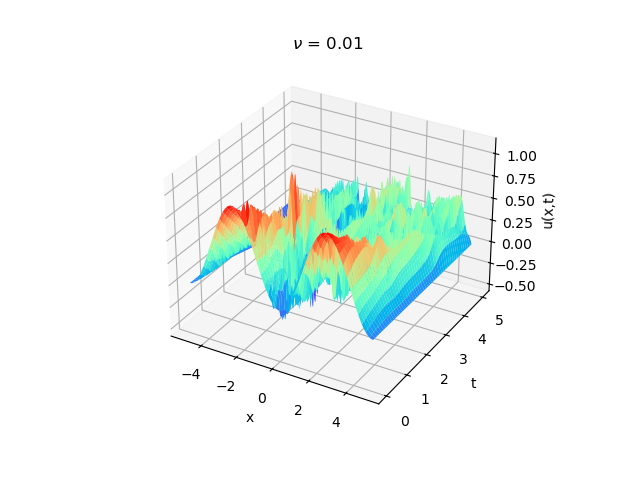

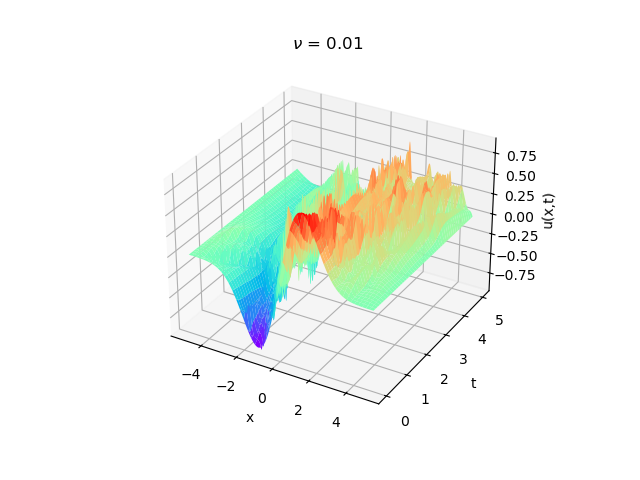

In [ ]:
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# Show solution #
for head in range(solver.n_heads):
    solver.best_nets = solver.best_nets_list[head] # Fix the nets to the best nets #
    solver.conditions = solver.all_conditions[:,head] # Fix the conditions to the best conditions #
    sol = solver.get_solution(best= True)     # Get solution #
    x = torch.linspace(-5,5,1000)
    t = torch.linspace(0,5,1000)
    xx,tt = torch.meshgrid(x,t)
    nu = nu_list[0]*torch.ones_like(xx)
    u = sol(xx,tt,nu,to_numpy = True)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a surface plot
    surf = ax.plot_surface(xx.cpu().detach().numpy(),
                           tt.cpu().detach().numpy(),
                           u, 
                           cmap=cm.rainbow, edgecolor='none')

    # Add a color bar to show the height
    #fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    ax.set_title('$\\nu$ = ' + str(nu[0,0].item()))
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x,t)')
    plt.savefig(plot_path + 'solution_nu_' + str(round(nu[0,0].item(),3))+ '.pdf')

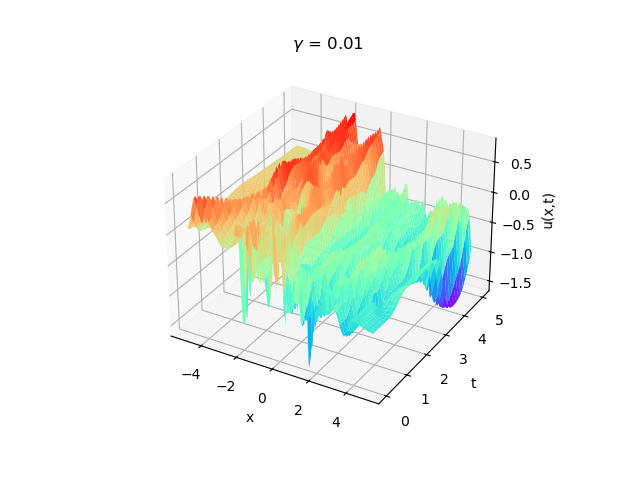

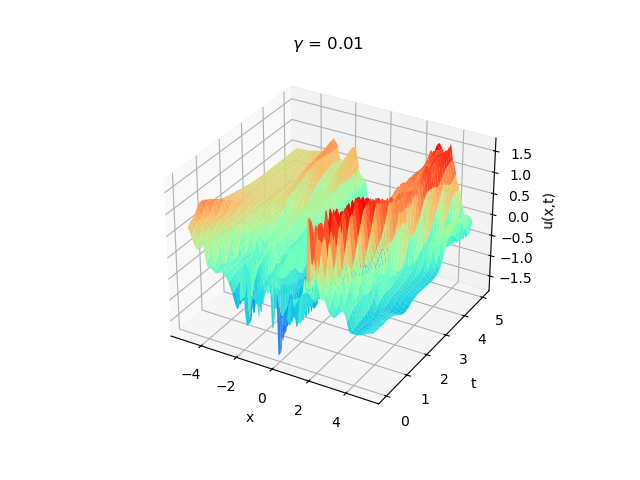

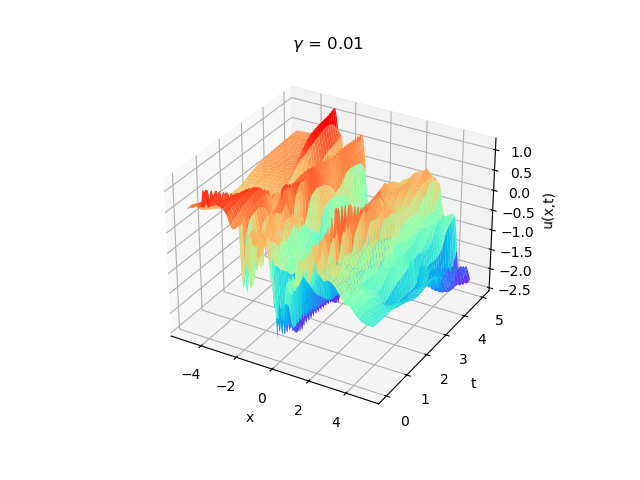

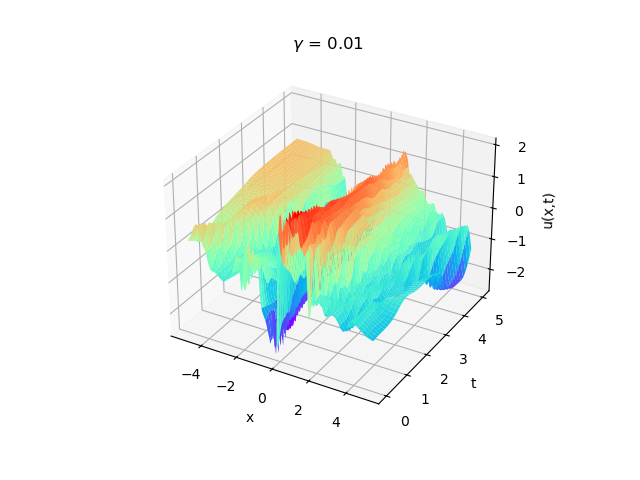

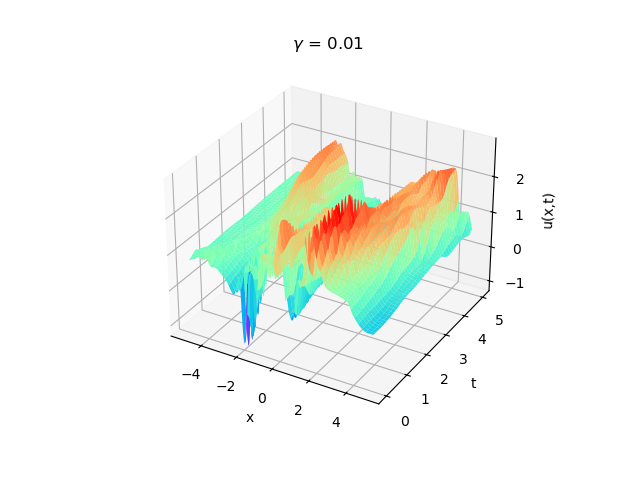

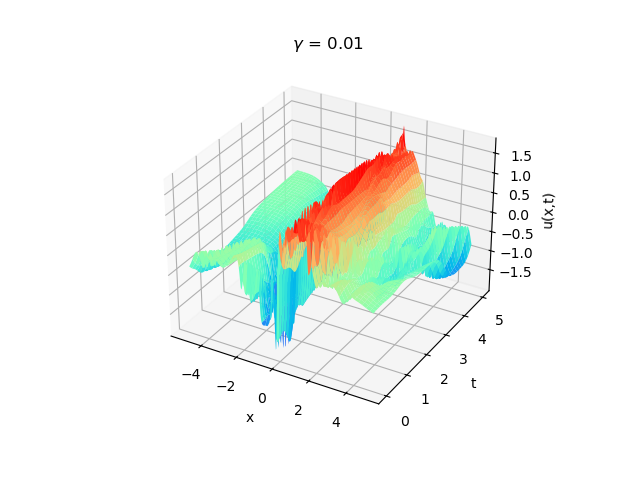

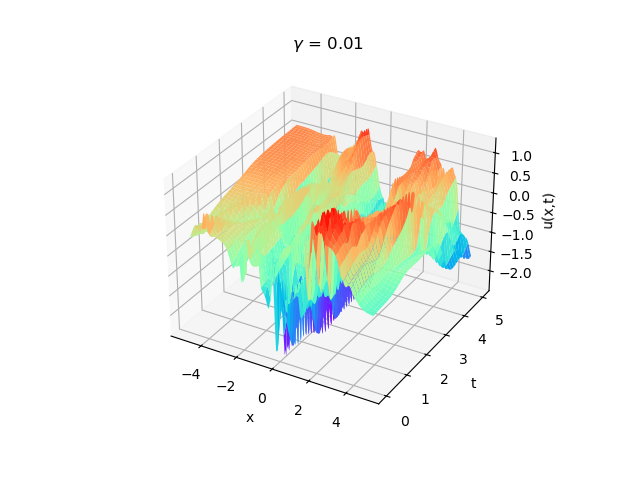

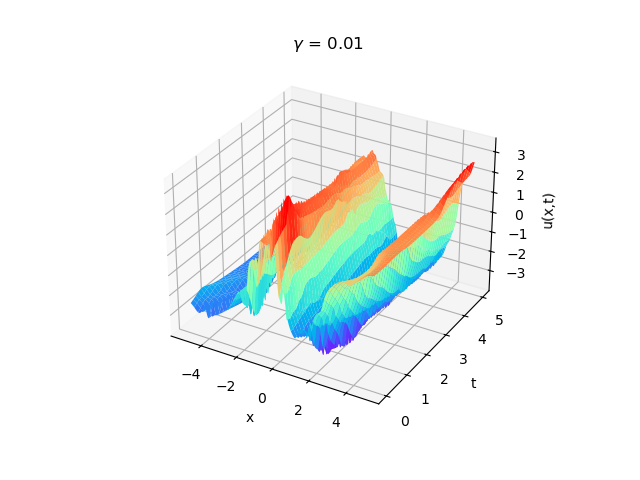

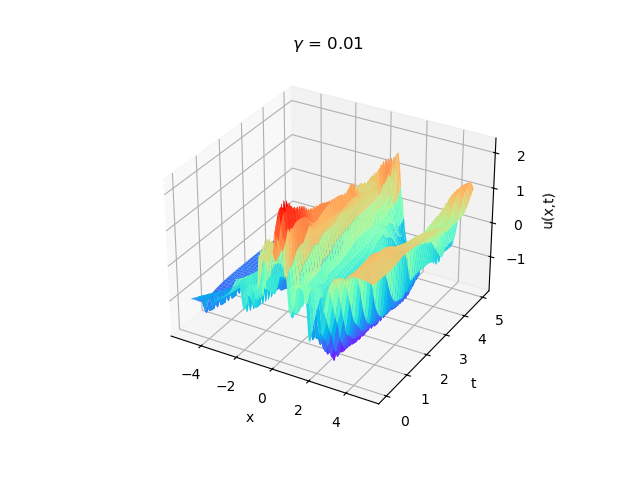

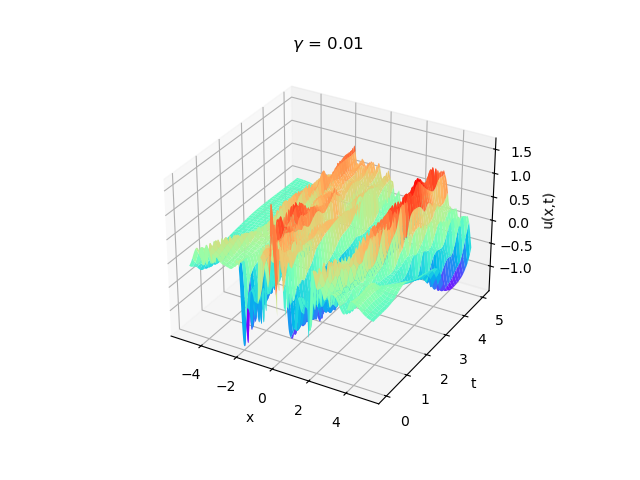

In [ ]:
# Show latent space basis #
%matplotlib widget
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
for head in range(1):
    solver.best_nets = solver.best_nets_list[head] # Fix the nets to the best nets #
    solver.conditions = solver.all_conditions[:,head]
    x = torch.linspace(-5,5,500)
    t = torch.linspace(0,5,503)
    xx,tt = torch.meshgrid(x,t)
    xx = xx.unsqueeze(dim = 2)
    tt = tt.unsqueeze(dim = 2)
    nu = nu_list[0]*torch.ones_like(xx)
    omega = torch.stack([xx,tt,nu],dim = 2).squeeze()
    u = solver.best_nets[0].H_model(omega)

    xx = xx.squeeze()
    tt = tt.squeeze()
    # Create a surface plot
    for i in range(u.shape[2]):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(xx.cpu().detach().numpy(),
                               tt.cpu().detach().numpy(),
                               u[:,:,i].cpu().detach().numpy(), 
                               cmap=cm.rainbow, edgecolor='none')

    # Add a color bar to show the height
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel('u(x,t)')
        ax.set_title('$\gamma$ = ' + str(nu[0,0].item()))
        plt.savefig(plot_path + 'H_' + str(i) + '_nu_' + str(round(nu[0,0].item(),3))+ '.pdf')

In [ ]:
### import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from pdf2image import convert_from_path

for heads in range(basis_length):
    # Paths to your PDF files
    # Iterate over H nu pdf files to make the gifst #
    

    pdf_paths = [plot_path + "H_" + str(heads) + "_nu_" + str(round(nu.item(),3)) + ".pdf" for nu in torch.tensor(nu_list)]


    # Convert PDFs to images
    images = [convert_from_path(pdf, first_page=0, last_page=1)[0] for pdf in pdf_paths]

    # Define the animation function
    def animate(i):
        ax.clear()
        ax.imshow(images[i])
        ax.axis('off')  # Hide axes for a clean look

    # Create the figure
    fig, ax = plt.subplots()

    # Create the animation
    ani = FuncAnimation(
        fig,
        animate,
        frames=len(images),
        interval=500,  # Time between frames in milliseconds
        repeat=True
    )

    # Save or display the animation
    ani.save(plot_path+"pdf_animation_dim_"+str(heads)+".gif", writer='ffmpeg', dpi=300)
    plt.show()


ModuleNotFoundError: No module named 'pdf2image'

In [ ]:
%matplotlib inline

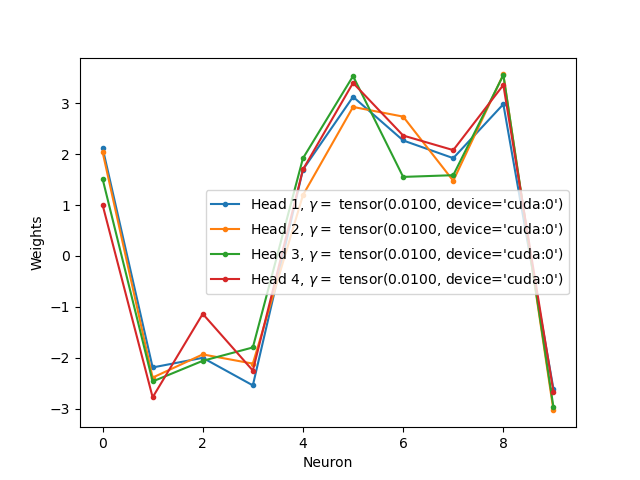

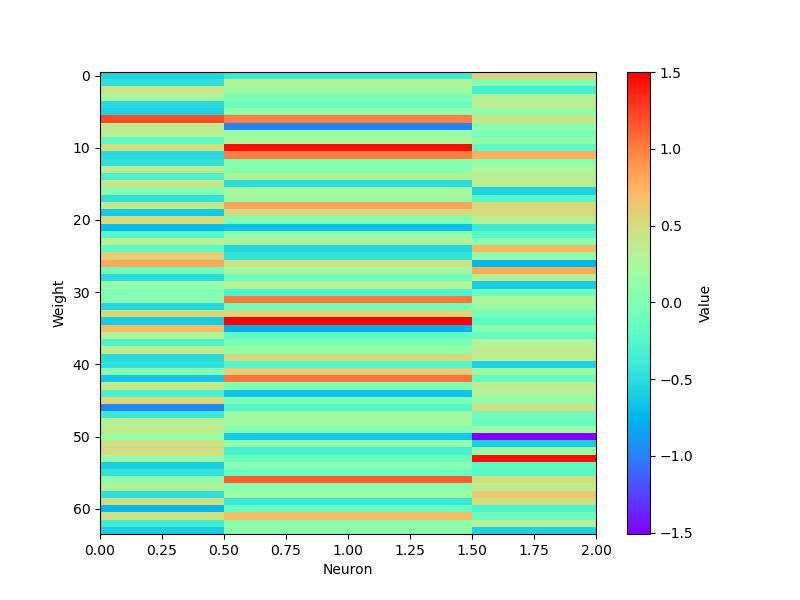

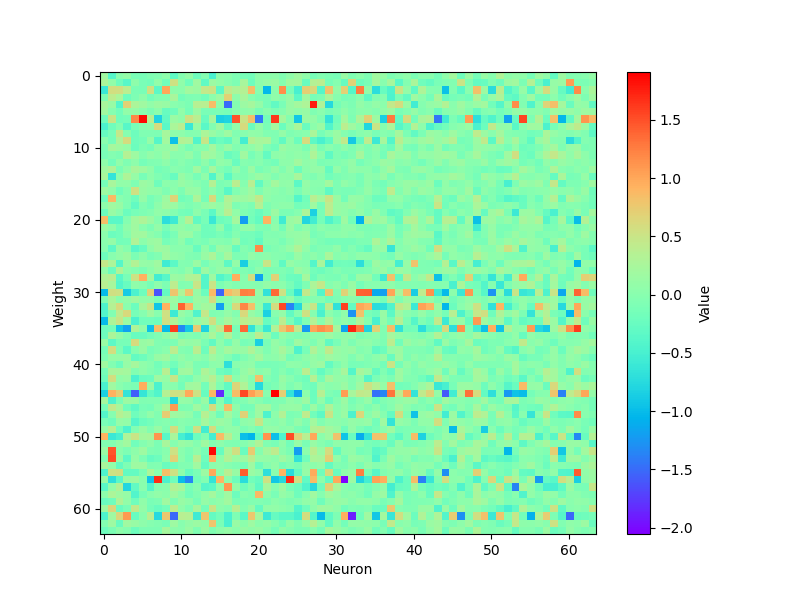

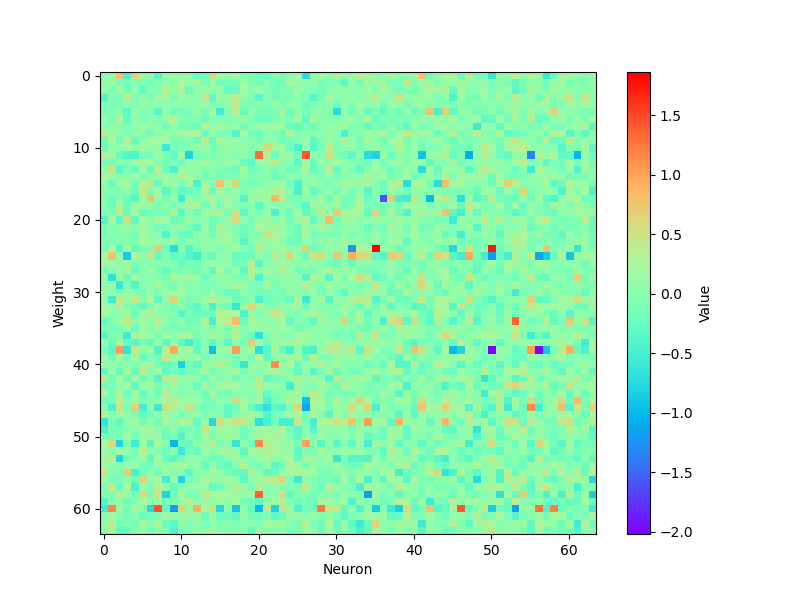

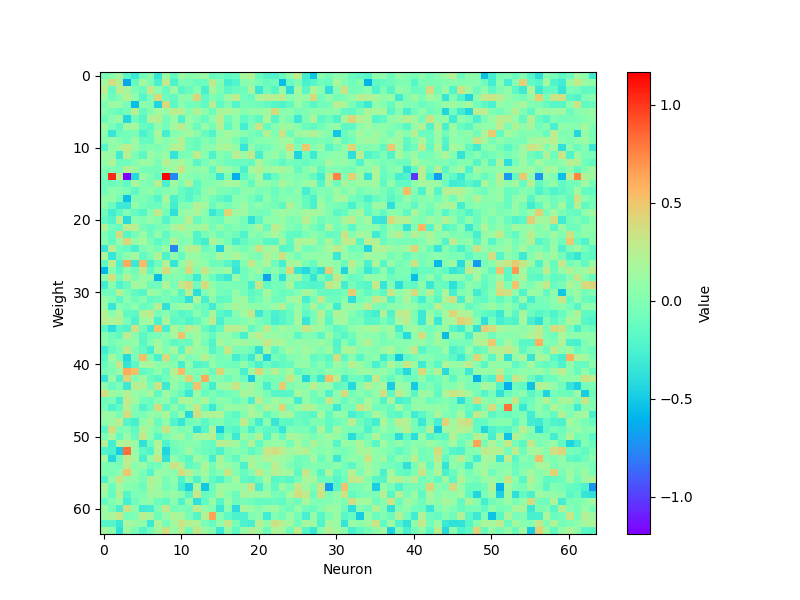

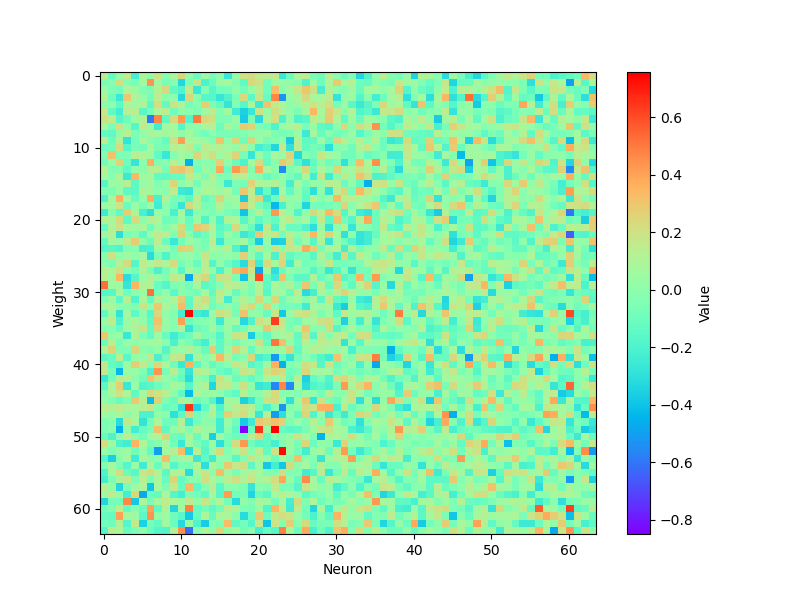

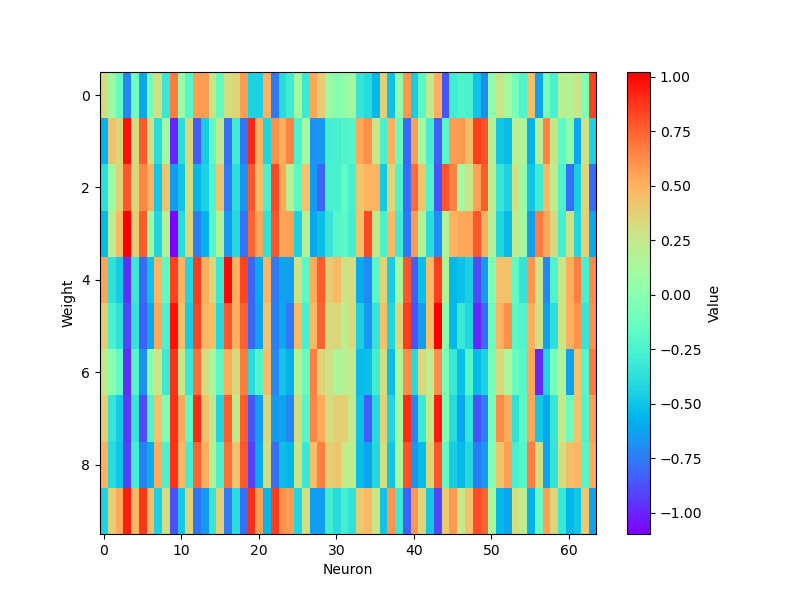

In [ ]:
plt.figure()
for heads in range(solver.n_heads):
    h_weights = nets[0,heads].head_model.weight
    plt.plot(h_weights.cpu().detach().numpy()[0],label = 'Head ' + str(heads + 1) + ', $\gamma = $ ' + str(nu_list[0]),marker = '.')#,linestyle = 'none')
plt.legend()
plt.xlabel('Neuron')
plt.ylabel('Weights')
plt.savefig(plot_path+'head_weight.pdf')
plt.show()

body_layers = nets[0,0].H_model.NN
for i in range(0,len(body_layers),2):
    plt.figure(figsize=(8,6))
    plt.imshow(body_layers[i].cpu().weight.detach().numpy(),cmap = 'rainbow',aspect='auto')
    if i==0:
        plt.xlim(0,2)
    plt.colorbar(label = 'Value')
    plt.xlabel('Neuron')
    plt.ylabel('Weight')
    plt.savefig(plot_path+'body_weight_layer_' + str(i+1) + '.pdf')
    plt.show()

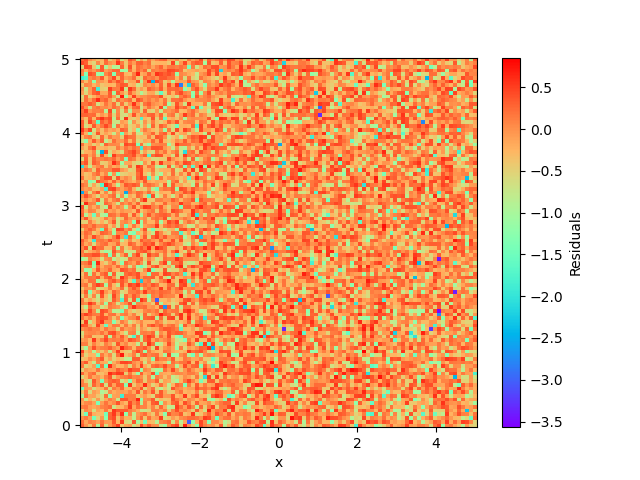

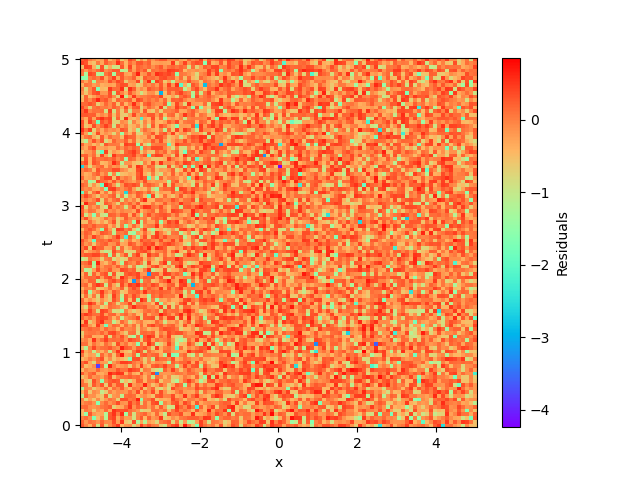

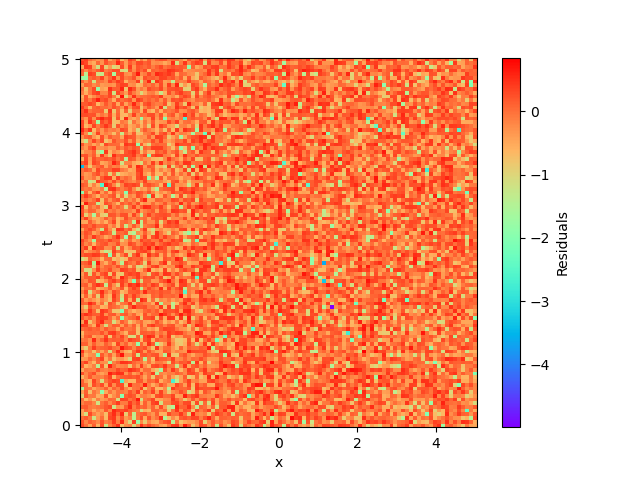

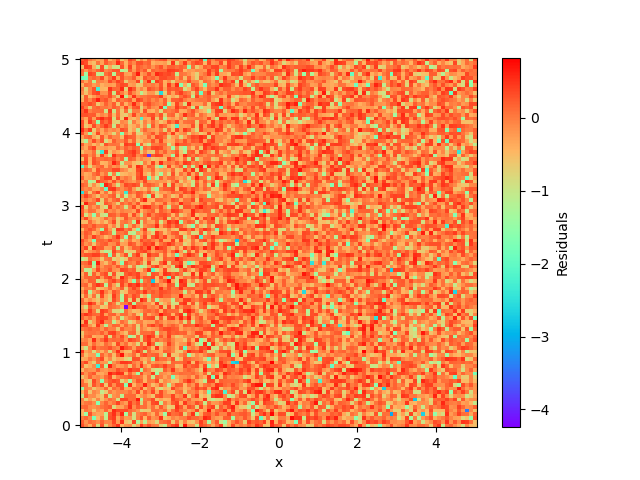

In [ ]:
# Plot residuals #
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
# Show solution #
for head in range(solver.n_heads):
    solver.best_nets = solver.best_nets_list[head] # Fix the nets to the best nets #
    solver.conditions = solver.all_conditions[:,head]
    #sol = solver.get_residuals(xbest= True)    # Get solution #
    x = torch.linspace(-5,5,100)
    t = torch.linspace(0,5,100)
    xx,tt,nn = torch.meshgrid(x,t,nu_list)
    nu = nu_list[0]*torch.ones_like(xx)
    u =  solver.get_residuals(xx,tt,nn,best= True)
    plt.figure()
    # Create a surface plot
    plt.pcolormesh(xx[::,::,0].cpu().detach().numpy(),
    tt[::,::,0].cpu().detach().numpy(),
    np.log10(abs(u[::,::,0].cpu().detach().numpy())),cmap = 'rainbow')

    # Add a color bar to show the height
    plt.colorbar(label = 'Residuals')
    plt.xlabel('x')
    plt.ylabel('t')

    plt.savefig(plot_path + 'res_nu_' + str(round(nu[0,0,0].item(),3))+ '.pdf')
    plt.show()

In [ ]:
from matplotlib import cm
from ipywidgets import interact, IntSlider

# Load nets from the previous code #
body_units = [64,64,64,64,64]
basis_length = 10

nu_pos = 24

# Create the body and the nets #
H = [FCNN(n_input_units=3, hidden_units= body_units, n_output_units = basis_length) for _ in range(1)]

H_loaded = torch.load('Plots/Burgers_bundle/Burguers_102854')['H_state']
H[0].load_state_dict(H_loaded)
print('Model loaded succesfully')

# Plot the latent space components #
x = torch.linspace(-5,5,101)
t = torch.linspace(0,5,103)
nu = nu_list
xx,tt,nunu = torch.meshgrid(x,t,nu,indexing = 'ij')
xx = xx.unsqueeze(dim = 3)
tt = tt.unsqueeze(dim = 3)
nunu = nunu.unsqueeze(dim = 3)
data_for_Paco = np.ones([xx.shape[0],xx.shape[1],xx.shape[2],basis_length+3])
data_for_Paco[::,::,::,0] = xx.squeeze().cpu().detach().numpy()
data_for_Paco[::,::,::,1] = tt.squeeze().cpu().detach().numpy()
data_for_Paco[::,::,::,2] = nunu.squeeze().cpu().detach().numpy()
for head in range(1):
    omega = torch.stack([xx, tt, nunu], dim=3).squeeze()
    u = H[0](omega)
    print(u.shape)
    data_for_Paco[::, ::, ::, 3::] = u.squeeze().cpu().detach().numpy()
    xx_np = data_for_Paco[:, :, 0, 0]
    tt_np = data_for_Paco[:, :, 0, 1]

    import matplotlib.animation as animation

    fig = plt.figure(figsize=(12, 8))

    axes = []
    surfs = []

    # Create subplots for each latent space component
    for i in range(basis_length):
        ax = fig.add_subplot(2, (basis_length+1)//2, i+1, projection='3d')
        axes.append(ax)
        surf = ax.plot_surface(
            xx_np,
            tt_np,
            data_for_Paco[:, :, nu_pos, i+3],
            cmap=cm.rainbow, edgecolor='none'
        )
        surfs.append(surf)
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel(f'u_{i}(x,t)')
        ax.set_title(f'Latent {i+1}, nu={nu_list[nu_pos]:.3f}')

    plt.tight_layout()

    def update(nu_idx):
        for i, ax in enumerate(axes):
            ax.clear()
            surf = ax.plot_surface(
                xx_np,
                tt_np,
                data_for_Paco[:, :, nu_idx, i+3],
                cmap=cm.rainbow, edgecolor='none'
            )
            ax.set_xlabel('x')
            ax.set_ylabel('t')
            ax.set_zlabel(f'u_{i}(x,t)')
            ax.set_title(f'Latent {i+1}, nu={nu_list[nu_idx]:.3f}')
        plt.suptitle(f'nu index: {nu_idx}', fontsize=16)
        return axes

    ani = animation.FuncAnimation(
        fig, update, frames=len(nu_list), interval=500, blit=False, repeat=True
    )

    # Save the animation as a gif
    ani.save('latent_space_animation.gif', writer='pillow', fps=2)

    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Plots/Burgers_bundle/Burguers_102854'

In [ ]:
np.load('Plots/Burgers_bundle/data_for_Paco_turbulence_bundle.npy').shape

(101, 103, 25, 13)

In [ ]:
# Load model #
adam = torch.optim.Adam([ p for q in range(n_heads) for net in list(nets[:,q]) for p in net.parameters()],
                        lr=1e-5)
print(adam)
# Initialize the solver

solver = MHSolver2D(pde_system=equation_list,
                   conditions= init_cond,
                    all_nets= nets,
                    nu_list = nu_list,
                    train_generator = None,
                    valid_generator = None,
                    xy_min= (x_min,t_min), xy_max=(x_max,t_max),
                    eq_param_index = (0,),
                    n_batches_valid = 0,
                    n_batches_train = 1,
                    n_samplings =100,
                    optimizer = adam
                   )
print(nets[0,0])
adam.param_groups[0]['lr'] = 1e-6
load_nets(solver=solver, nets=nets, optim=adam, path='Plots/MH_m3_to_0_H_linear_more_points/Burguers_50006')
print(adam)
solver.fit(1)

In [ ]:
# Symbolic regression #
import os
os.environ["JULIA_NUM_THREADS"] = "4"  # Set to 4 threads before importing PySR
from pysr import PySRRegressor
from matplotlib import cm
from pysr import PySRRegressor
from scipy.io import savemat

# First we need to create the data set that we want to fit #
# In this case what we are going to try to fit are the basis functions of the latent space #
# We first try it with one head (one value for nu) and different elements of the basis functions #
n_points = 200
H_all = torch.ones([n_points,n_points+1,basis_length,n_heads])
for head in range(n_heads):
    solver.best_nets = solver.best_nets_list[head] # Fix the nets to the best nets #
    x = torch.linspace(-5,5,n_points)
    t = torch.linspace(0,5,n_points + 1)
    xx,tt = torch.meshgrid(x,t)
    
    xx = xx.unsqueeze(dim = 2)
    tt = tt.unsqueeze(dim = 2)
    nu = nu_list[head]*torch.ones_like(xx)
    omega = torch.stack([xx,tt,nu],dim = 2).squeeze()
    u = solver.best_nets[0].H_model(omega)
    H_all[:,:,:,head] = u
    xx = xx.squeeze()
    tt = tt.squeeze()
    # Create a surface plot
    for i in range(u.shape[2]):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        u_smooth = gaussian_smooth_2d(u[:, : ,i], sigma=20,kernel_size=7)
        surf = ax.plot_surface(xx.detach().numpy(),
                               tt.detach().numpy(),
                               u_smooth.detach().numpy(), 
                               cmap=cm.rainbow, edgecolor='none')
    # Add a color bar to show the height
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel('u(x,t)')
        ax.set_title('$\gamma$ = ' + str(nu[0,0].item()))
        fig2 = plt.figure()
        ax = fig2.add_subplot(111)
        cp = ax.pcolormesh(xx.detach().numpy(),
                      tt.detach().numpy(),
                      (u_smooth-u[:,:,i]).detach().numpy(),
                      cmap=cm.rainbow)
        fig2.colorbar(cp, ax=ax)
        


    for i in range(u.shape[2]):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        # Generate a colormap for the different time slices
        colormap = plt.cm.rainbow
        colors = colormap(np.linspace(0, 1, len(t)//10))  # 10 evenly spaced colors
        u_smooth = gaussian_smooth_2d(u[:, : ,i], sigma=20,kernel_size=7)

        for j, color in zip(range(0, len(t), int(len(t)/10)), colors):
            surf = ax.plot(
            x.detach().numpy(),
            u_smooth[:, j].detach().numpy(),
            color=color,  # Assign color from colormap
            label=f"t={t[j]:.2f}"  # Optional label for the legend
        )
            surf = ax.plot(
            x.detach().numpy(),
            u[:, j,i].detach().numpy(),
            color=color,  # Assign color from colormap
            label=f"t={t[j]:.2f}",  # Optional label for the legend
            linestyle = 'dashed'
        )
            
    

    # Add a color bar to show the height
        ax.set_xlabel('x')
        ax.set_ylabel('u(x)')
        ax.set_title('$\gamma$ = ' + str(nu[0,0].item()))


save_data_path = 'Plots/MH_m3_to_0_H_linear_more_points/simulations'
print(H_all.detach().numpy().shape)

# Check if directory exists, and if not, create it
if not os.path.exists(save_data_path):
    os.makedirs(save_data_path)
    print(f"Directory '{save_data_path}' created.")
else:
    print(f"Directory '{save_data_path}' already exists.")

savemat(save_data_path + '/latent_space.mat',{"array": H_all.detach().numpy()})
savemat(save_data_path + '/xx.mat',{"array": xx.detach().numpy()})
savemat(save_data_path + '/tt.mat',{"array": tt.detach().numpy()})

In [ ]:
# We have the data charged in u for a given value of the viscosity #
# We will now run the model and define the opertaros that we are going to perform #
# In principle we are going to define the default operators #
head = 0
solver.best_nets = solver.best_nets_list[head] # Fix the nets to the best nets #
x = torch.linspace(-5,5,50)
t = torch.linspace(0,5,51)
xx,tt = torch.meshgrid(x,t)
xx = xx.unsqueeze(dim = 2)
tt = tt.unsqueeze(dim = 2)
nu = nu_list[head]*torch.ones_like(xx)
omega = torch.stack([xx,tt,nu],dim = 2).squeeze()
u = solver.best_nets[0].H_model(omega)
xx = xx.squeeze()
tt = tt.squeeze()
# Create a surface plot
for i in range(u.shape[2]):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    u_smooth = gaussian_smooth_2d(u[:, : ,4], sigma=20,kernel_size=7)
    surf = ax.plot_surface(xx.detach().numpy(),
                            tt.detach().numpy(),
                            u_smooth.detach().numpy(), 
                            cmap=cm.rainbow, edgecolor='none')
# Add a color bar to show the height
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u(x,t)')
    ax.set_title('$\gamma$ = ' + str(nu[0,0].item()))
    fig2 = plt.figure()
    ax = fig2.add_subplot(111)
    cp = ax.pcolormesh(xx.detach().numpy(),
                    tt.detach().numpy(),
                    (u_smooth-u[:,:,i]).detach().numpy(),
                    cmap=cm.rainbow)
    fig2.colorbar(cp, ax=ax)


model = PySRRegressor(
    niterations=100,                # Allow more time for optimization
    populations=20,                 # Larger population for better diversity
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["sin", "cos", "exp", "sqrt", "log","square","cube"],
    maxsize=32,                     # Allow more complex equations
    progress=True
)
# We will also define x as the time and the position of the NN #
# And Y as a particular element of the latent space as a function of X, and for a particular value of the viscosity #

X = np.reshape(np.transpose(np.array([xx.numpy(),tt.numpy()]),(1,2,0)),(-1,2))
print(X.shape)
Y = np.reshape(u_smooth.detach().numpy(),(-1,1))
print(Y.shape)

In [ ]:
model.fit(X,Y)

In [ ]:
model.sympy()

In [ ]:
Ypredict = model.predict(X)
Ypredict = Ypredict.reshape(xx.shape[0],xx.shape[1])
Y_real  = Y.reshape(xx.shape[0],xx.shape[1])
plt.figure()
# Create a surface plot
plt.pcolormesh(xx,tt,Ypredict-Y_real,cmap = 'rainbow')

# Add a color bar to show the height
plt.colorbar(label = 'Diff. symbolic')
plt.xlabel('x')
plt.ylabel('t')
plt.title('$\gamma$ = ' + str(nu[0,0].item()))
#plt.savefig(plot_path + 'res_nu_' + str(round(nu[0,0].item(),0))+ '.pdf')
plt.show()

# Try to do the Wavelet fit using python 